In [1]:
import os
from coffea import hist
from coffea import util
import numpy as np
import itertools

In [2]:
dir = 'CoffeaOutputs/UnweightedOutputs/'

QCD_unweighted = util.load(dir+'TTbarResCoffea_QCD_unweighted_output_dask_5-19-21_MC_efficiency_test.coffea')
#TTbar_unweighted = util.load(dir+'TTbarResCoffea_TTbar_unweighted_output_dask_5-19-21_MC_efficiency_test.coffea')

In [3]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [4]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [5]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["Probet", "at", "0t", "pret", "1t", "1t+2t", "2t", "0t+1t+2t"] # 'Pt' = t-tagged probe
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

In [6]:
maindirectory = os.getcwd() 

In [7]:
stack_tag1_opts = {'marker': '.', 'markersize': 10., 'color': 'b', 'elinewidth': 1}
stack_tag2_opts = {'marker': 's', 'markersize': 5., 'color': 'g', 'elinewidth': 1}
legend_tag_opts = {'labels':['', '', 'DeepTag', 'DeepTag MD']}
stack_ttbar_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'red'}
stack_background_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3), 'color': 'yellow'}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'None', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

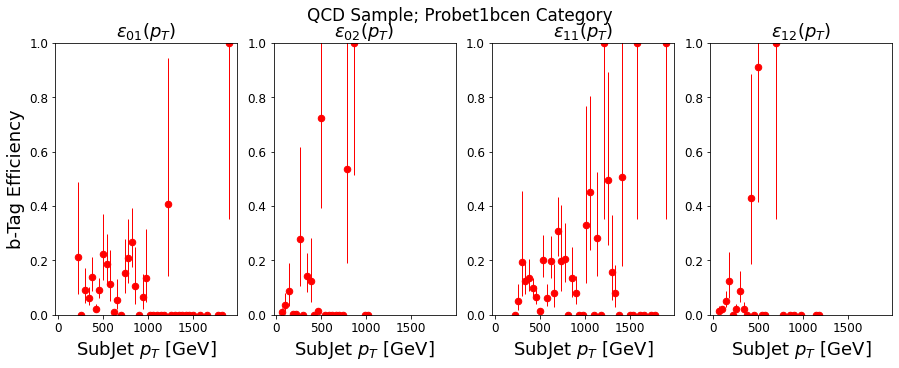

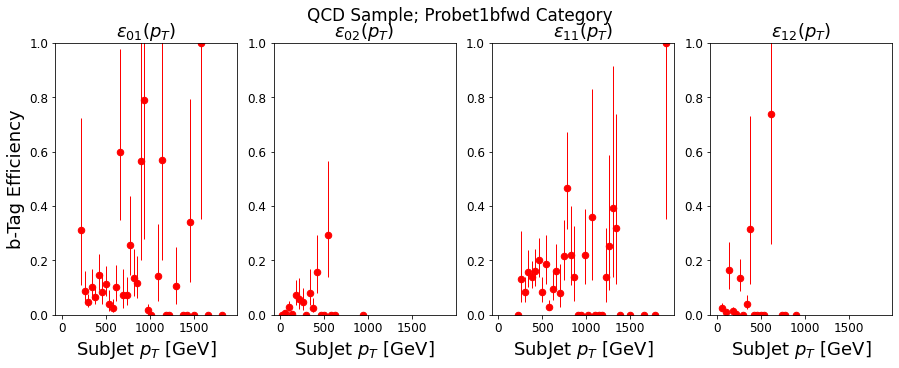

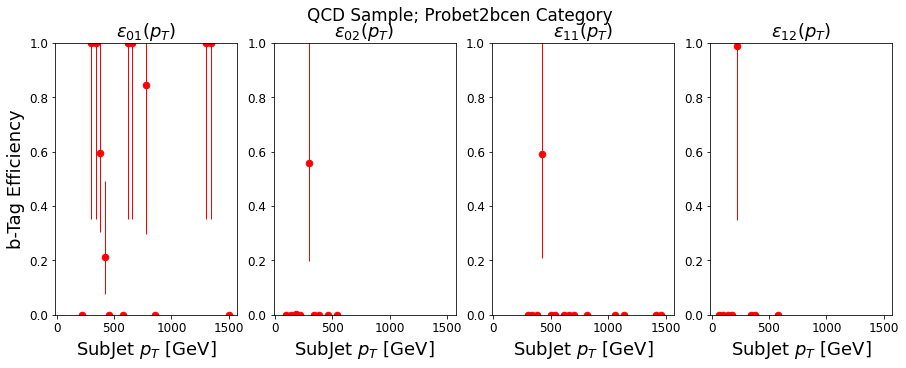

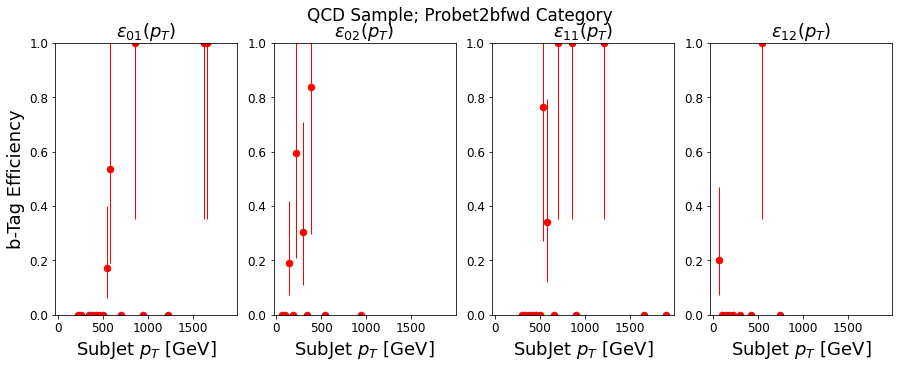

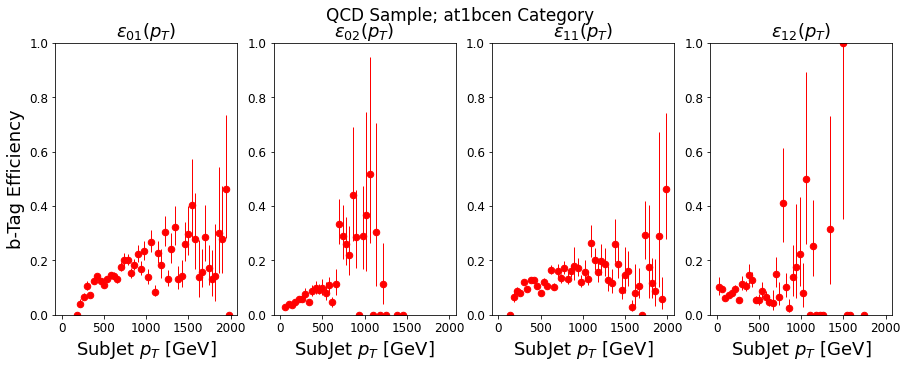

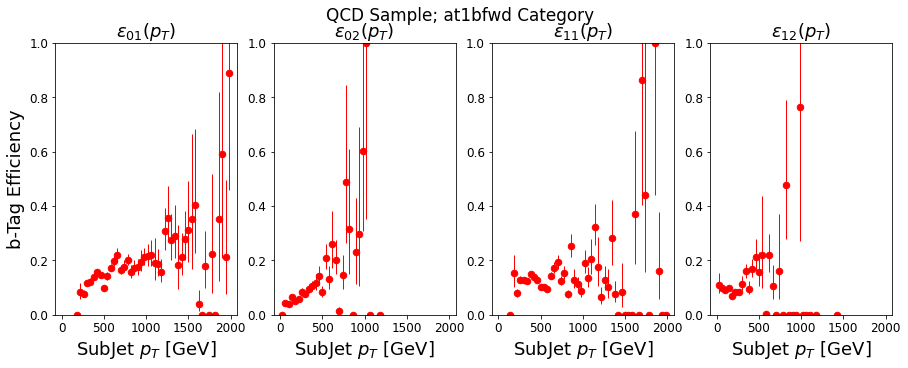

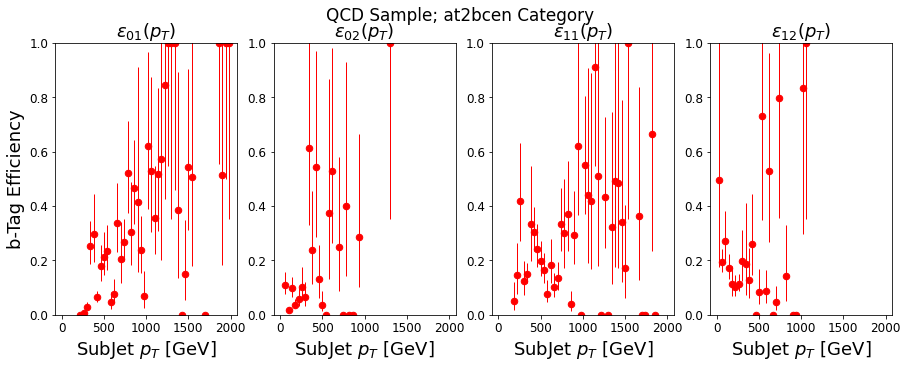

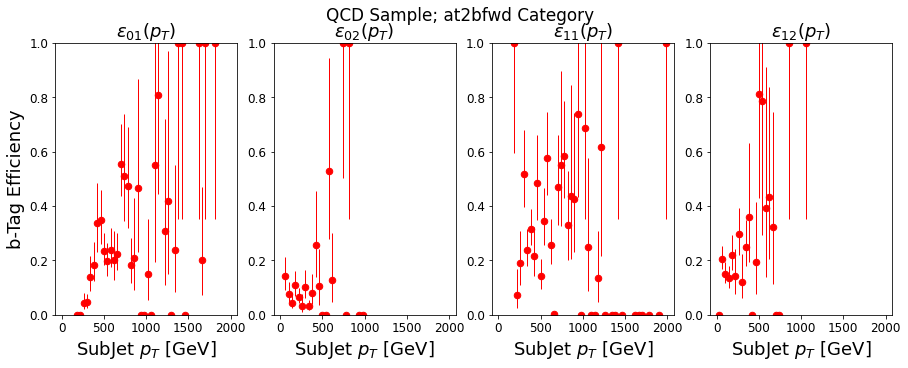

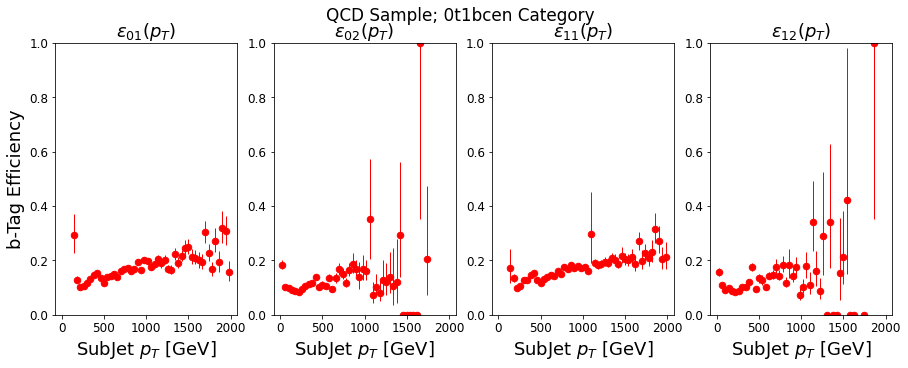

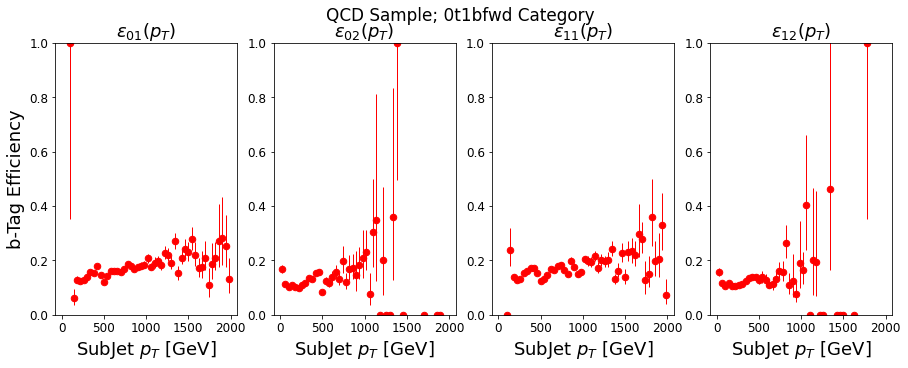

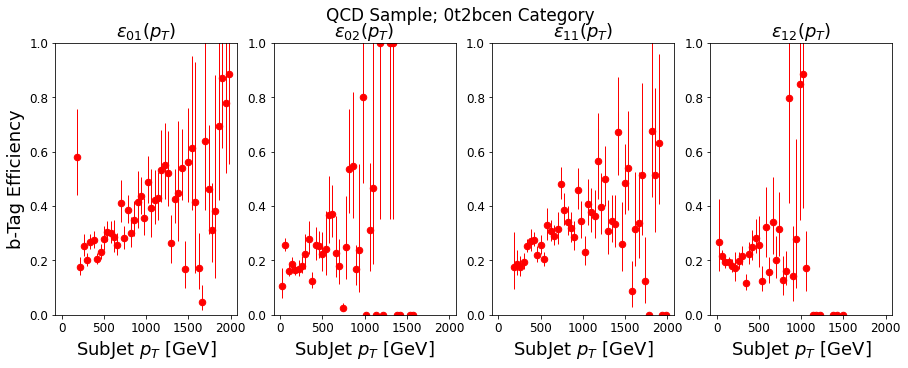

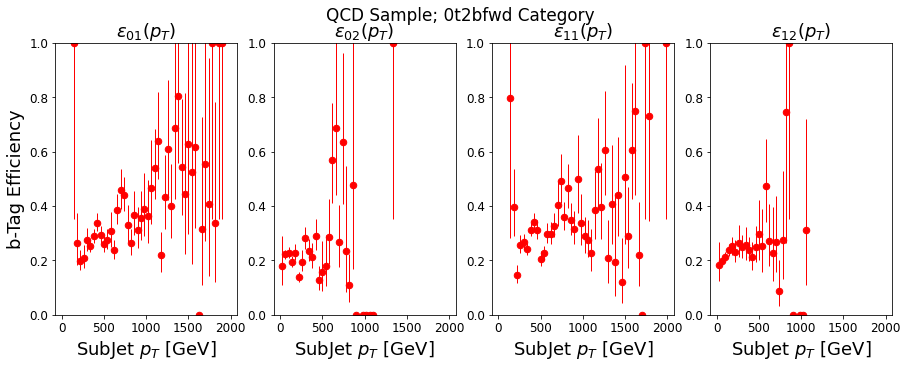

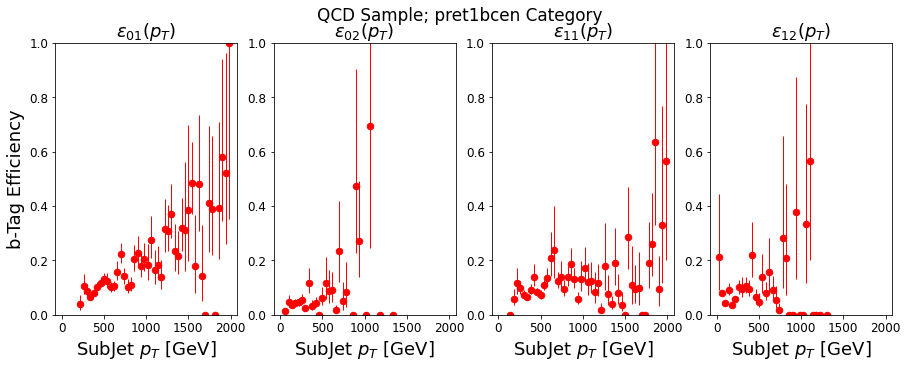

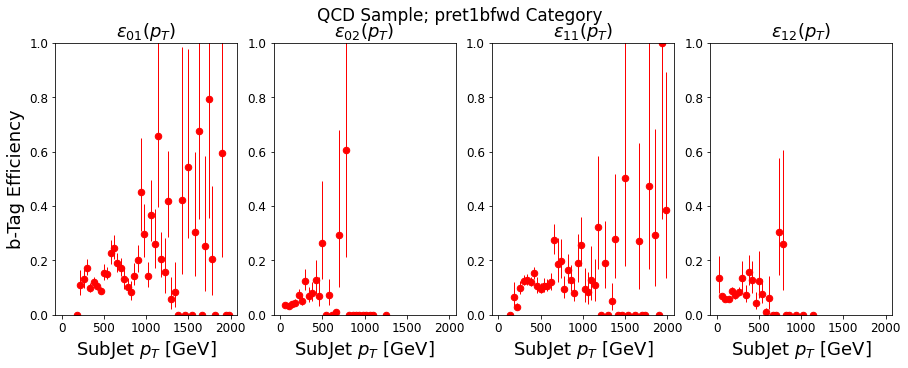

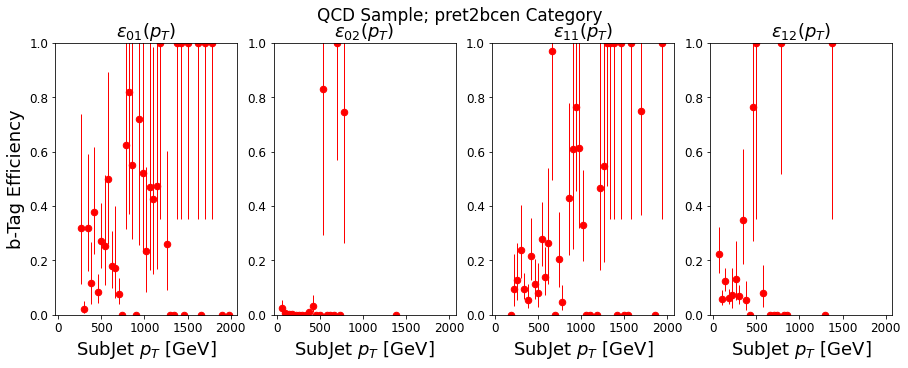

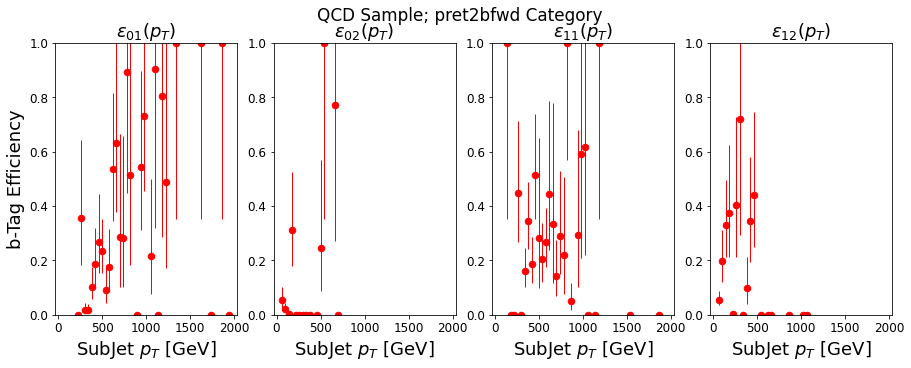

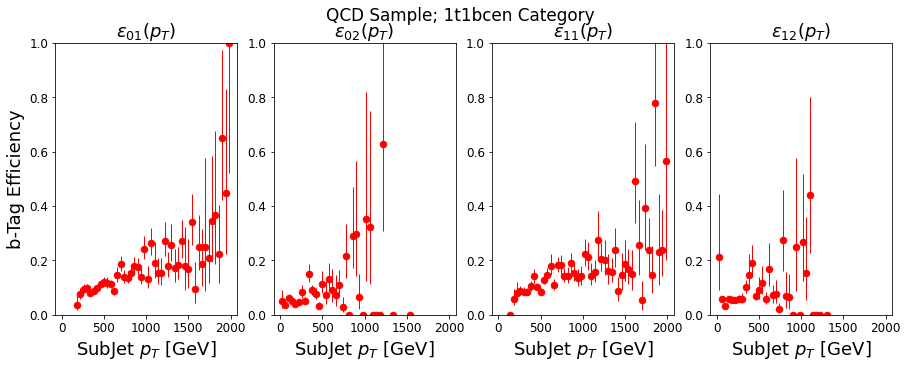

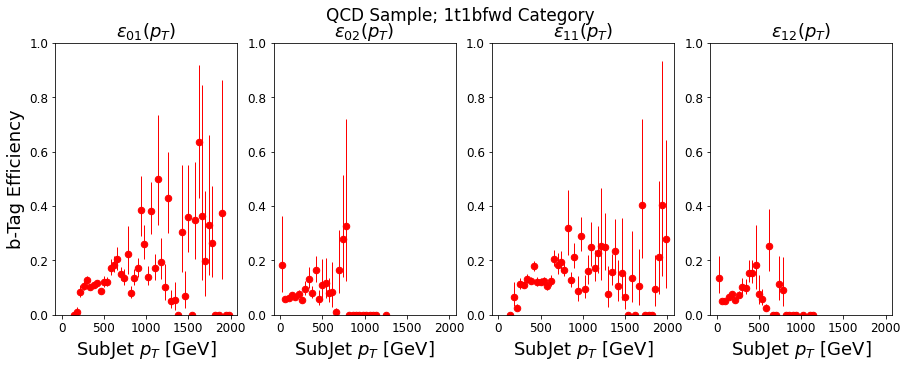

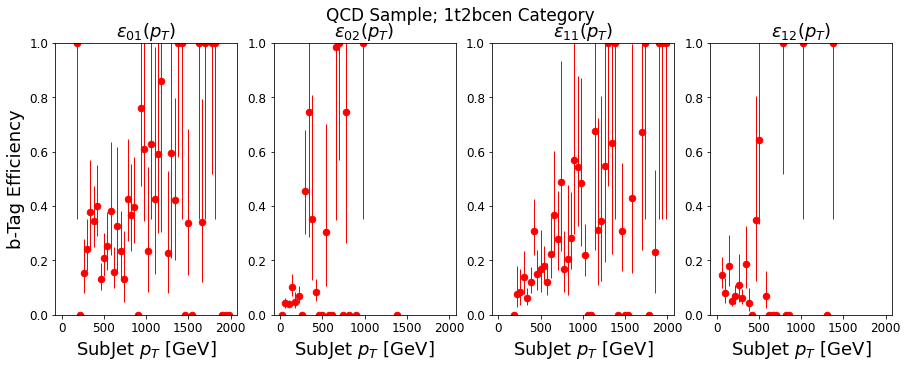

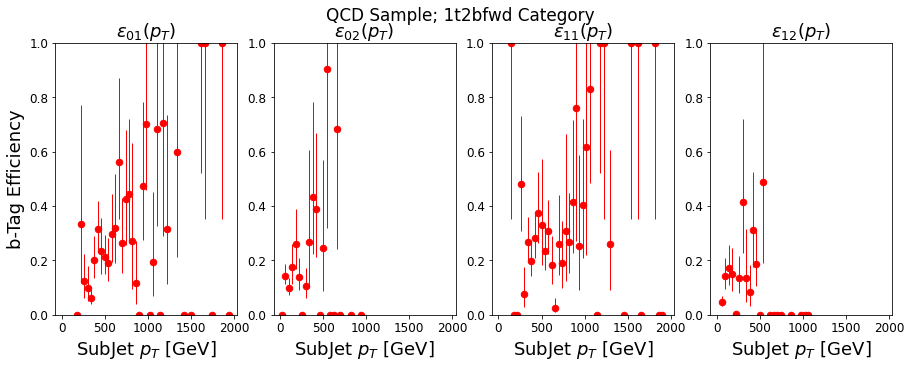

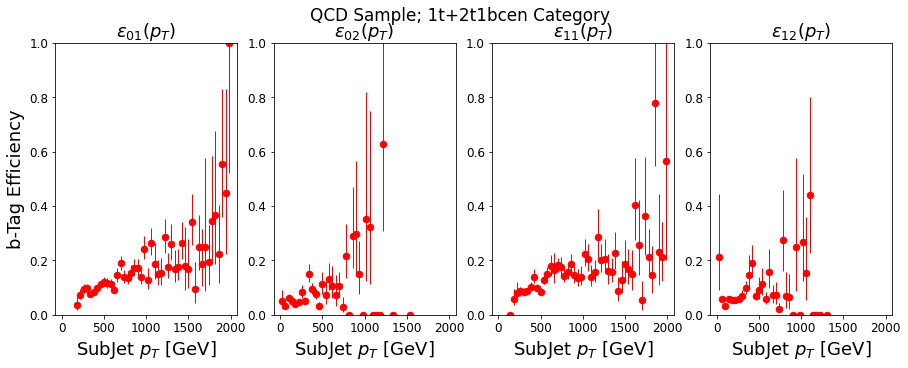

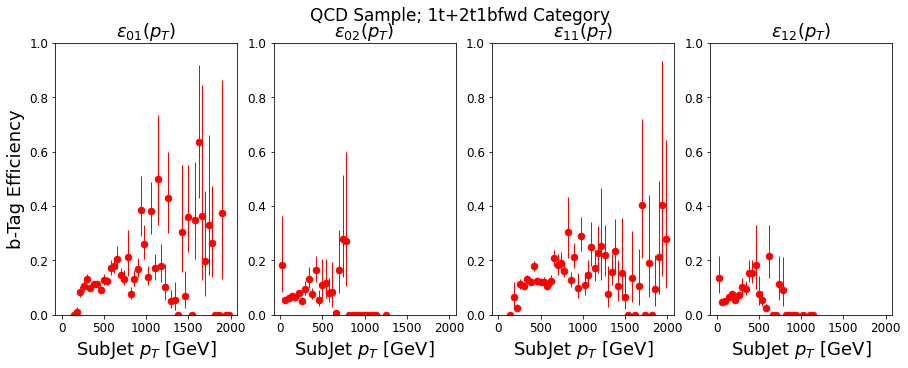

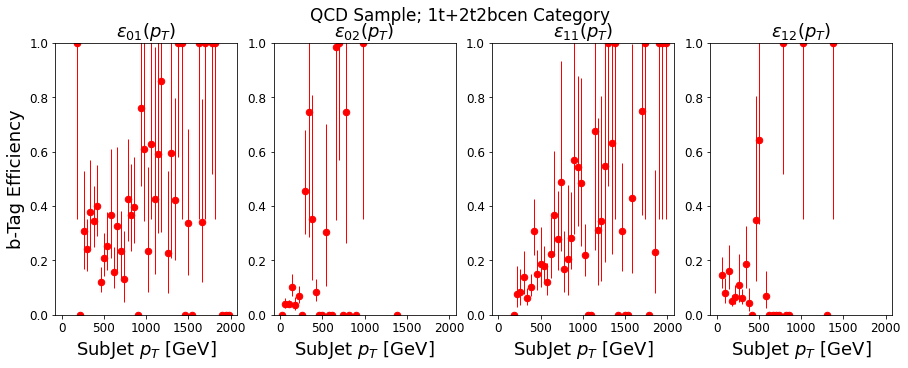

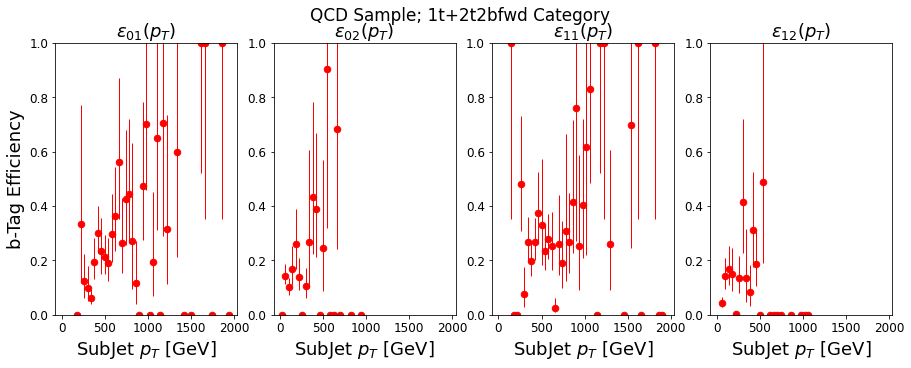

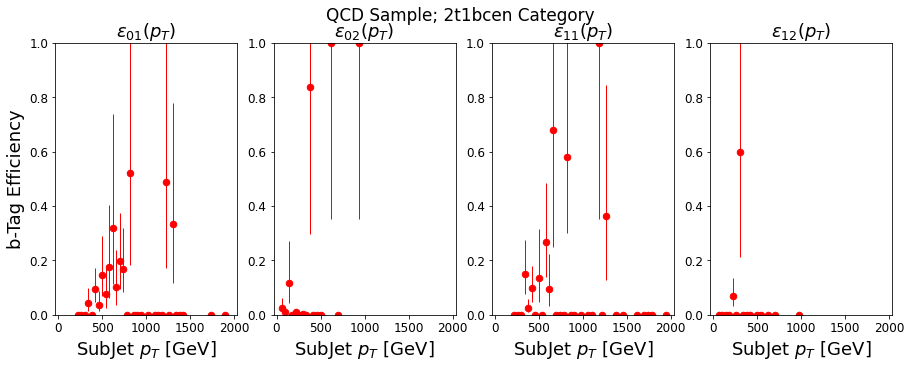

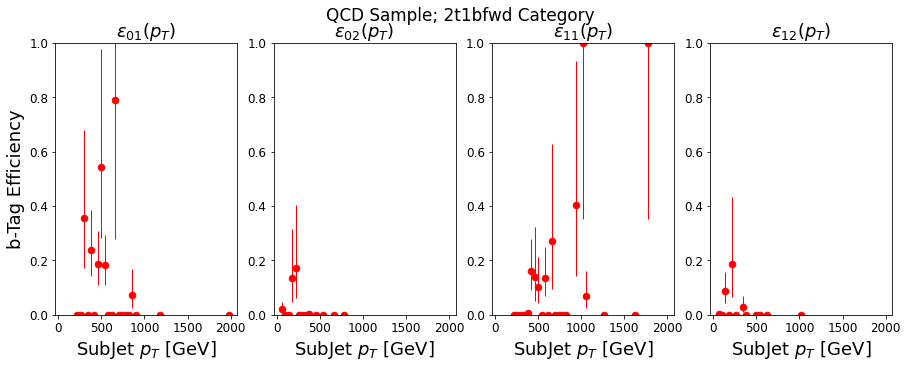

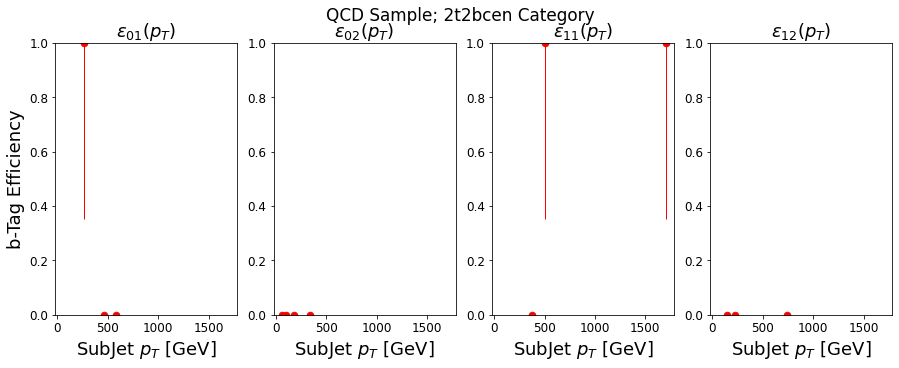

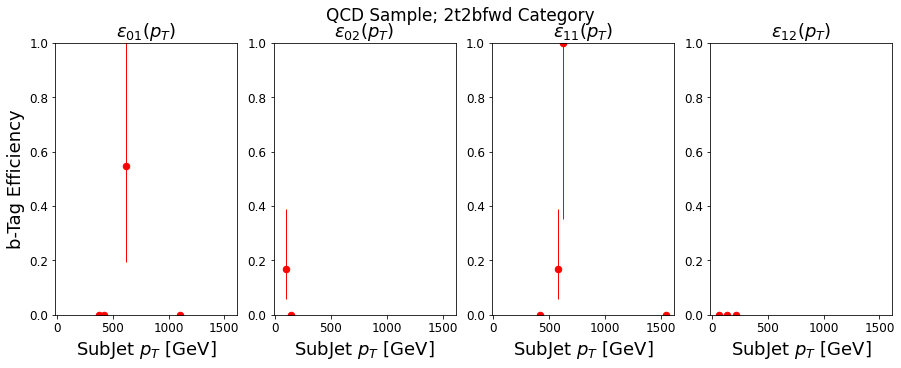

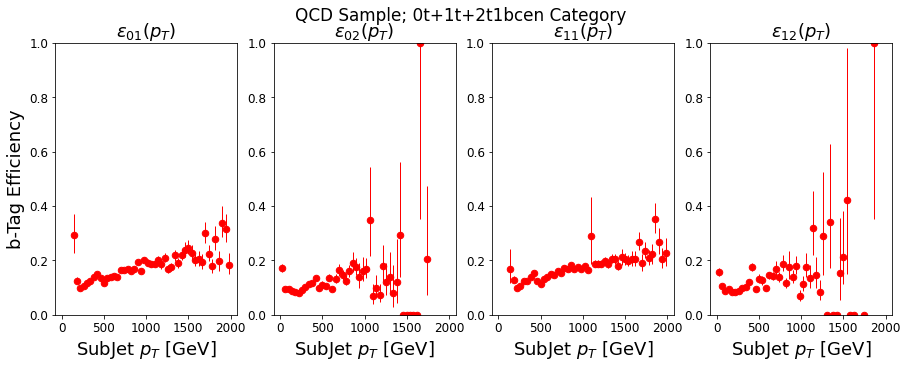

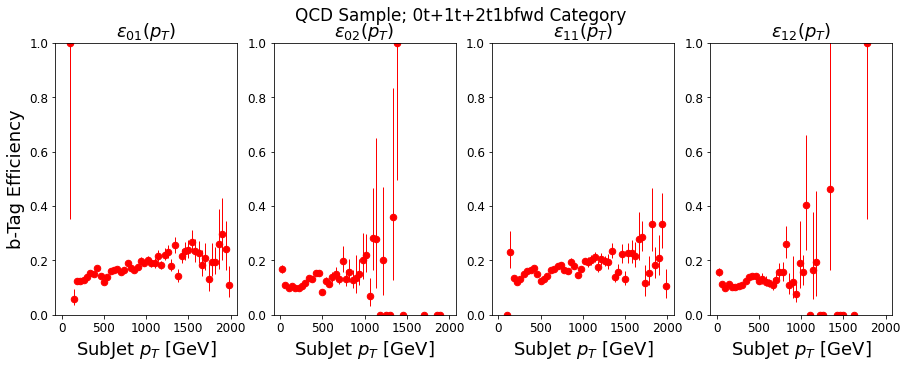

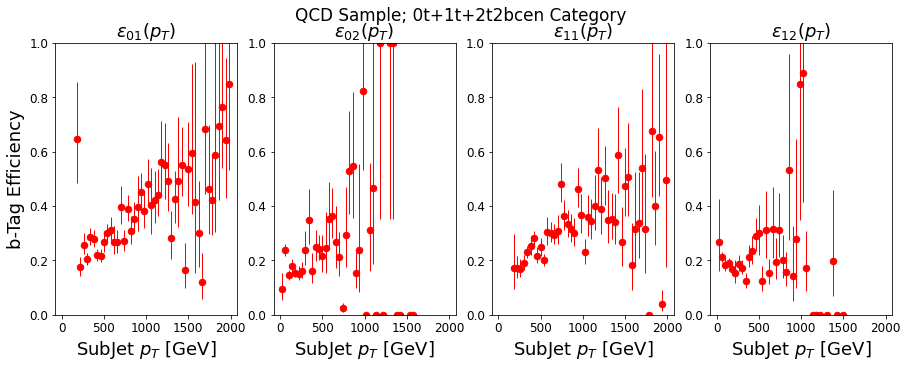

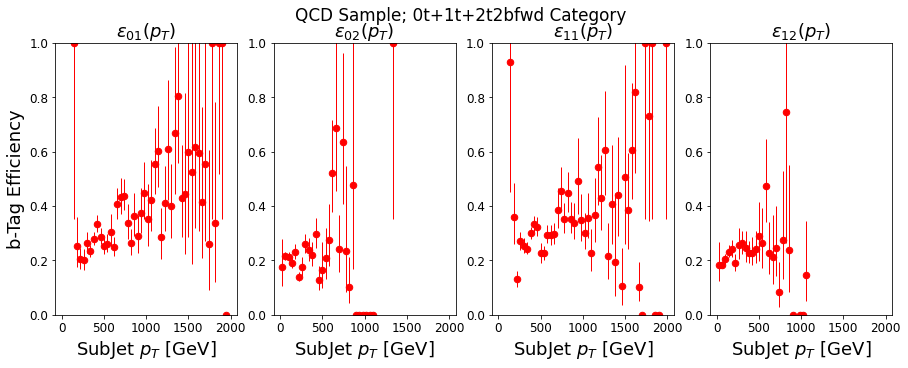

In [8]:
# SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
# DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
for icat in list_of_cats: 
    if not '0b' in icat:
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax01, ax02, ax11, ax12) = plt.subplots(1, 4, figsize=(15,5), sharex=True)

        QCD_b_eff_numerator_pt_s01 = QCD_unweighted['b_eff_numerator_pt_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_pt_s01 = QCD_unweighted['b_eff_denominator_pt_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_pt_s01 = hist.plotratio(num = QCD_b_eff_numerator_pt_s01, denom = QCD_b_eff_denominator_pt_s01, 
                                      ax=ax01, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax01.set_title(r'$\epsilon_{01}\left(p_T\right)$')
        ax01.set_ylabel('b-Tag Efficiency')
        ax01.set_ylim(bottom=0., top=1.)

        # ------------------------------------------------------------------------------ #

        QCD_b_eff_numerator_pt_s02 = QCD_unweighted['b_eff_numerator_pt_s02'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_pt_s02 = QCD_unweighted['b_eff_denominator_pt_s02'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_pt_s02 = hist.plotratio(num = QCD_b_eff_numerator_pt_s02, denom = QCD_b_eff_denominator_pt_s02, 
                                      ax=ax02, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax02.set_title(r'$\epsilon_{02}\left(p_T\right)$')
        ax02.set_ylabel('')
        ax02.set_ylim(bottom=0., top=1.)

        # ------------------------------------------------------------------------------ #

        QCD_b_eff_numerator_pt_s11 = QCD_unweighted['b_eff_numerator_pt_s11'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_pt_s11 = QCD_unweighted['b_eff_denominator_pt_s11'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_pt_s11 = hist.plotratio(num = QCD_b_eff_numerator_pt_s11, denom = QCD_b_eff_denominator_pt_s11, 
                                      ax=ax11, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax11.set_title(r'$\epsilon_{11}\left(p_T\right)$')
        ax11.set_ylabel('')
        ax11.set_ylim(bottom=0., top=1.)

        # ------------------------------------------------------------------------------ #

        QCD_b_eff_numerator_pt_s12 = QCD_unweighted['b_eff_numerator_pt_s12'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_pt_s12 = QCD_unweighted['b_eff_denominator_pt_s12'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_pt_s12 = hist.plotratio(num = QCD_b_eff_numerator_pt_s12, denom = QCD_b_eff_denominator_pt_s12, 
                                      ax=ax12, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax12.set_title(r'$\epsilon_{12}\left(p_T\right)$')
        ax12.set_ylabel('')
        ax12.set_ylim(bottom=0., top=1.)

        fig.suptitle('QCD Sample; ' + str(icat) + ' Category')
    else:
        continue

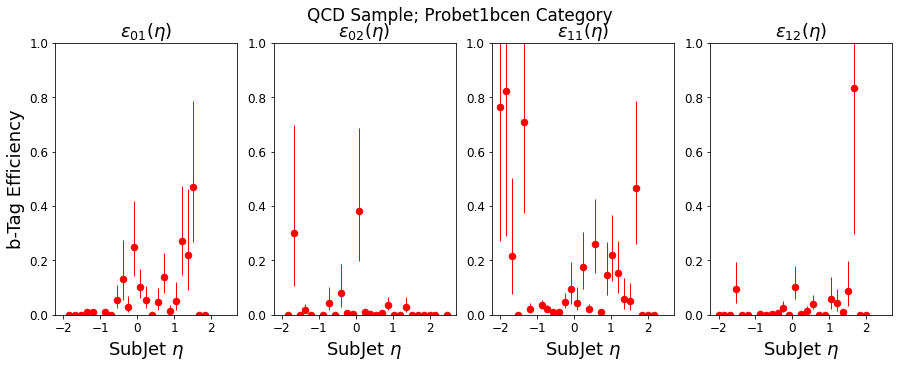

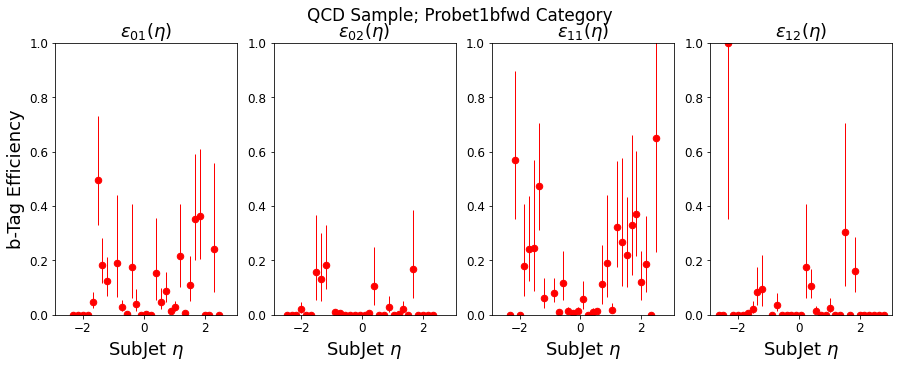

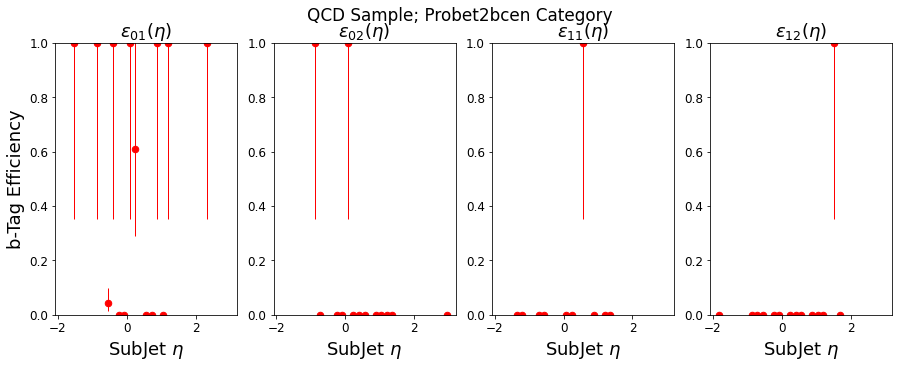

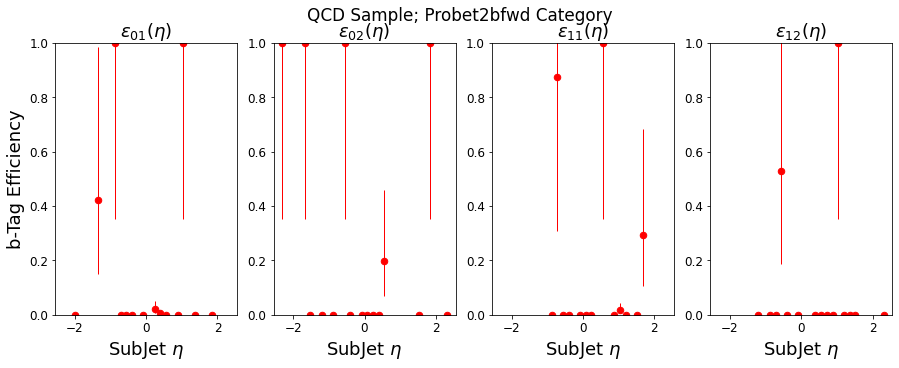

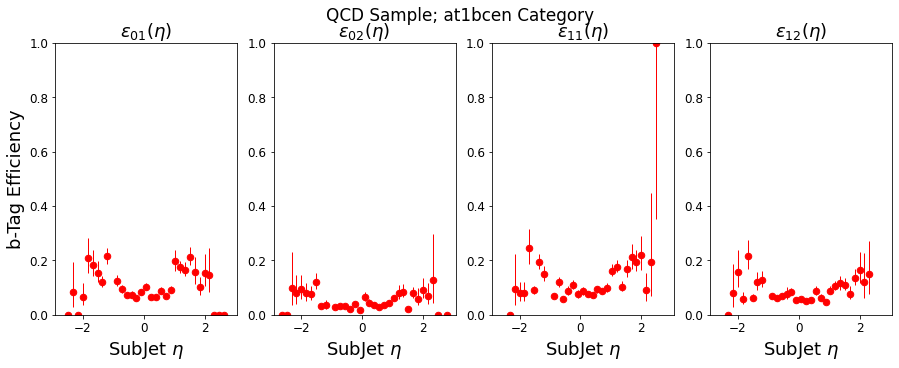

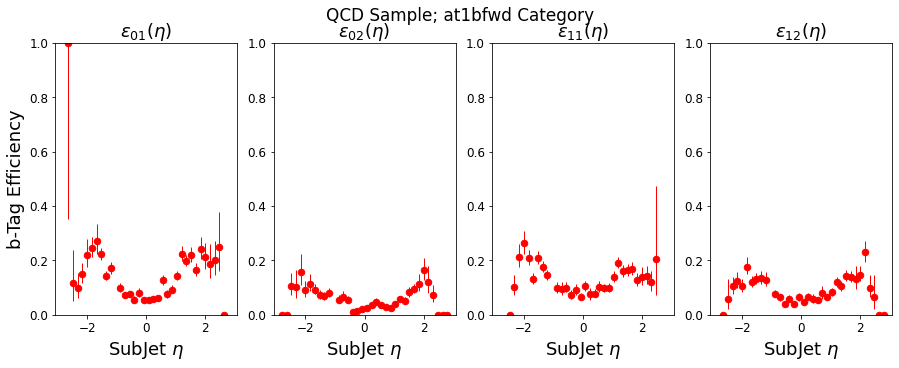

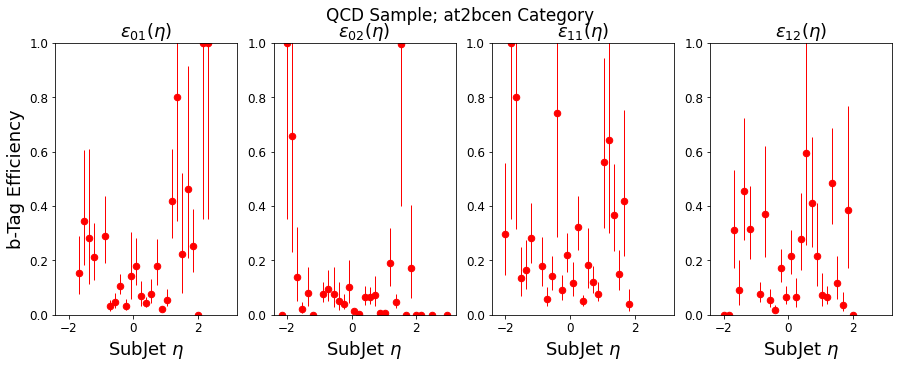

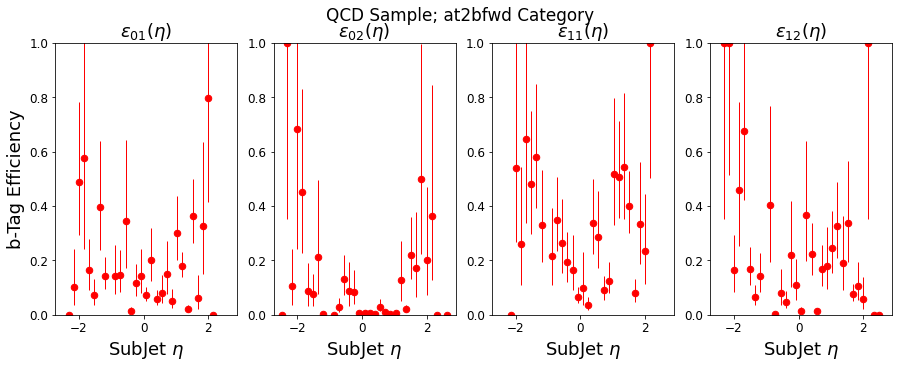

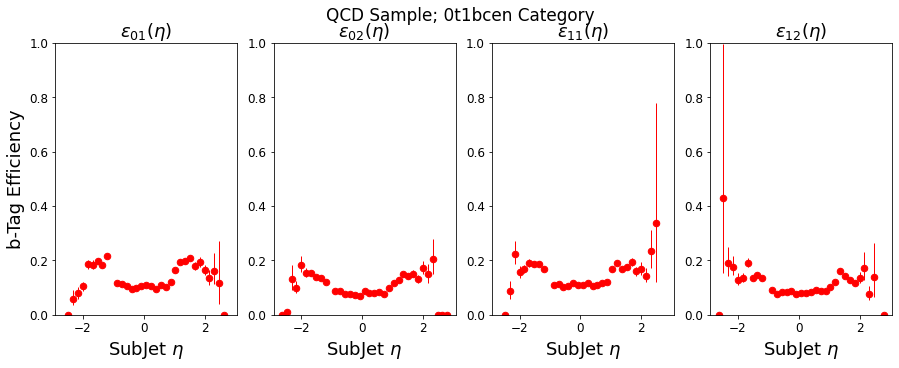

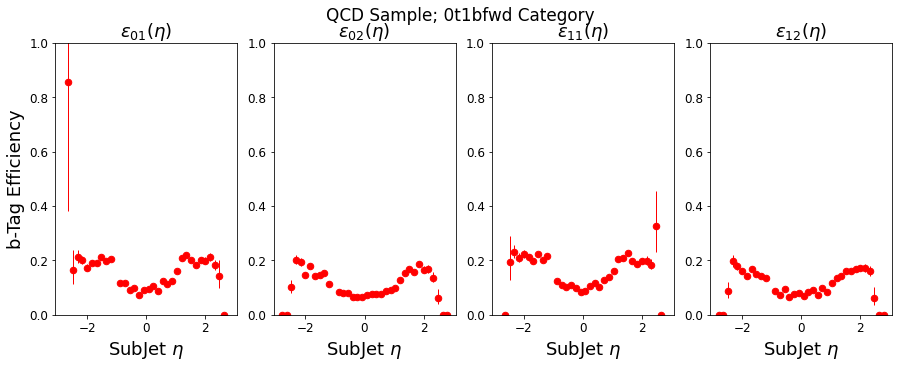

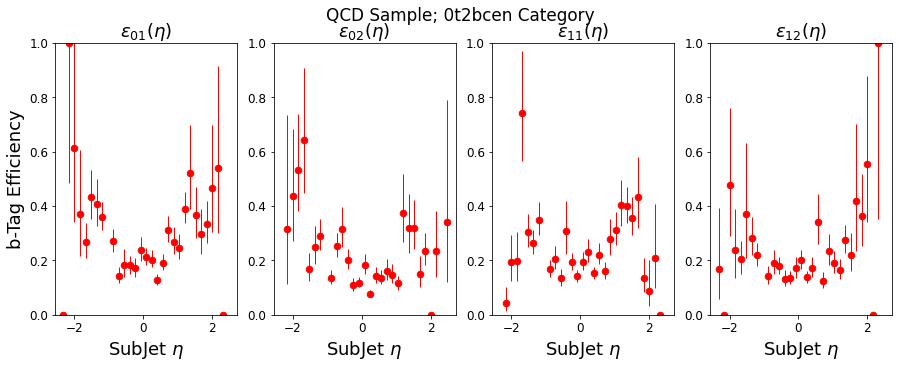

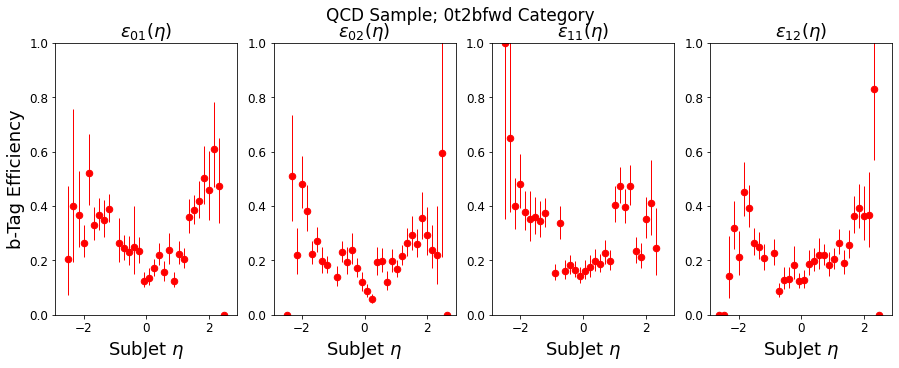

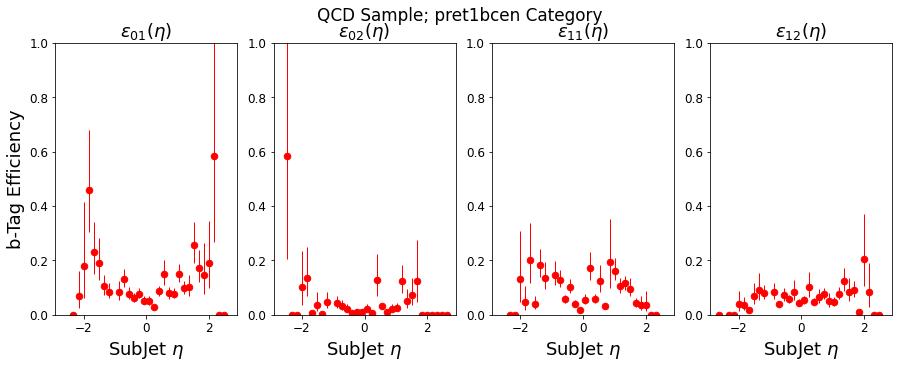

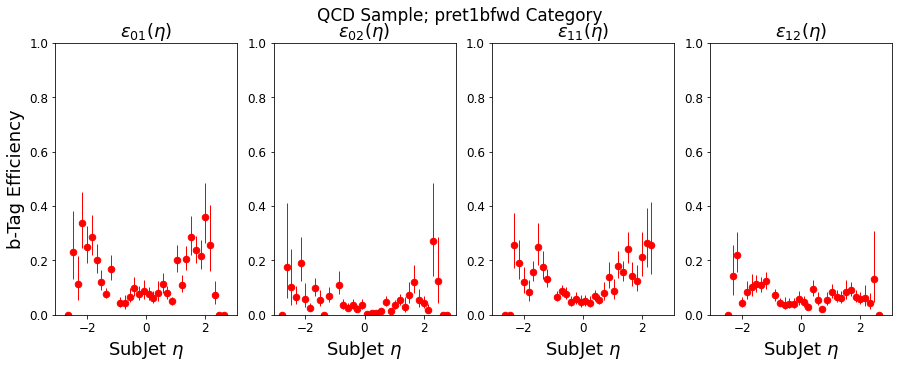

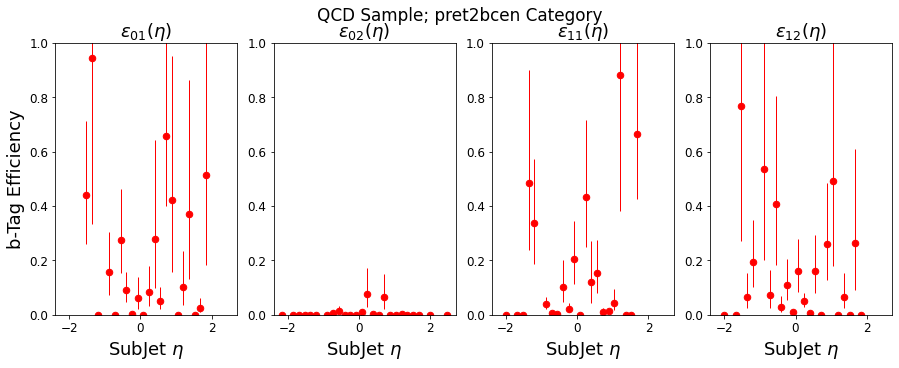

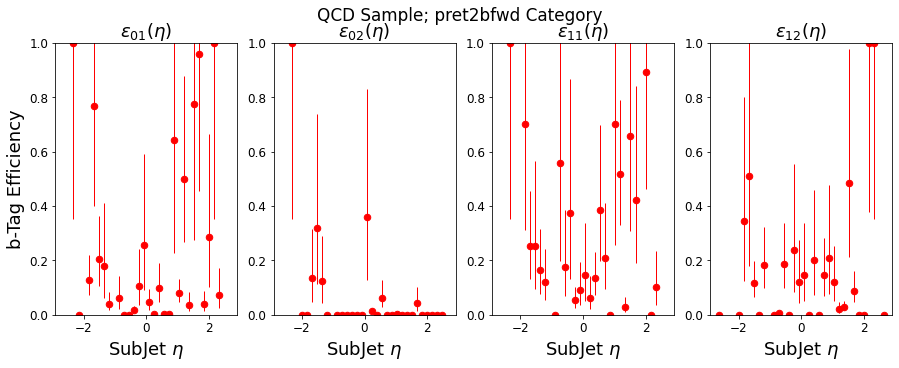

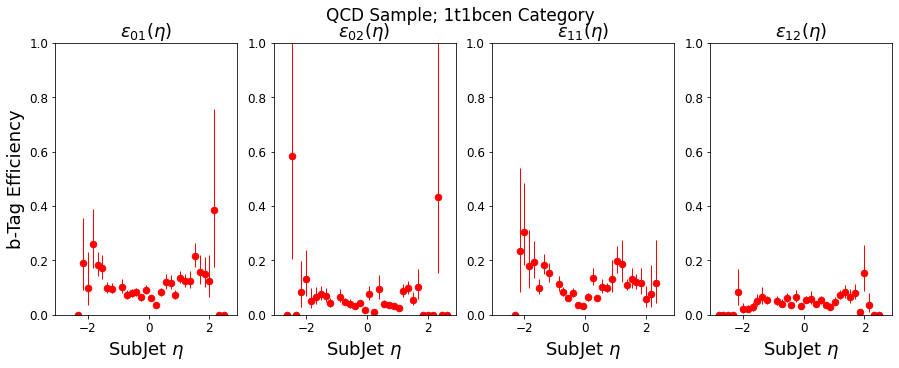

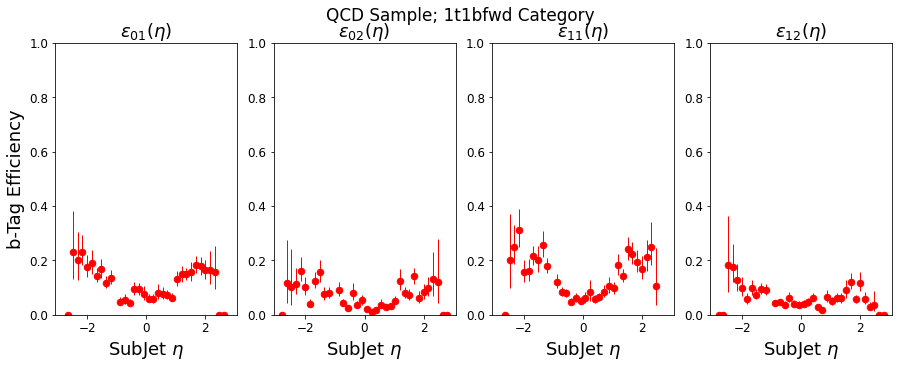

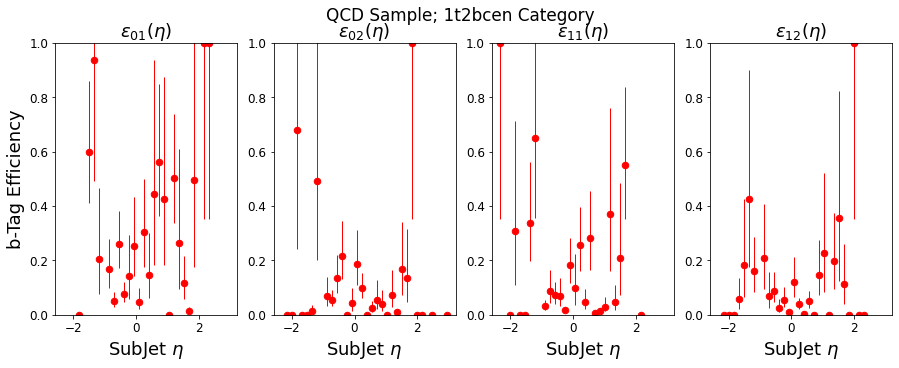

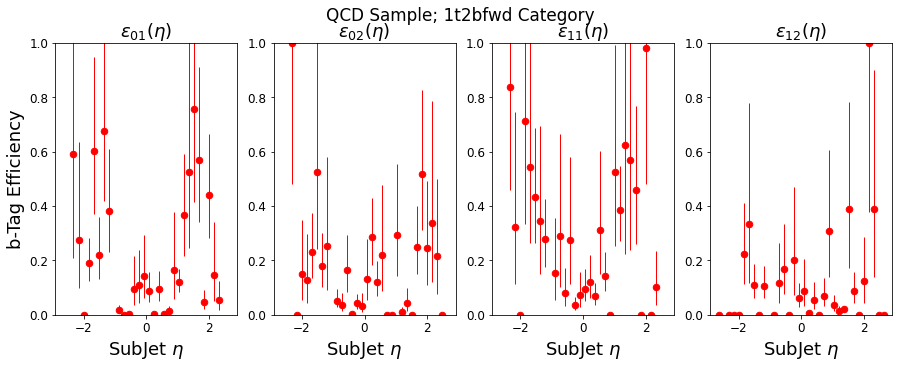

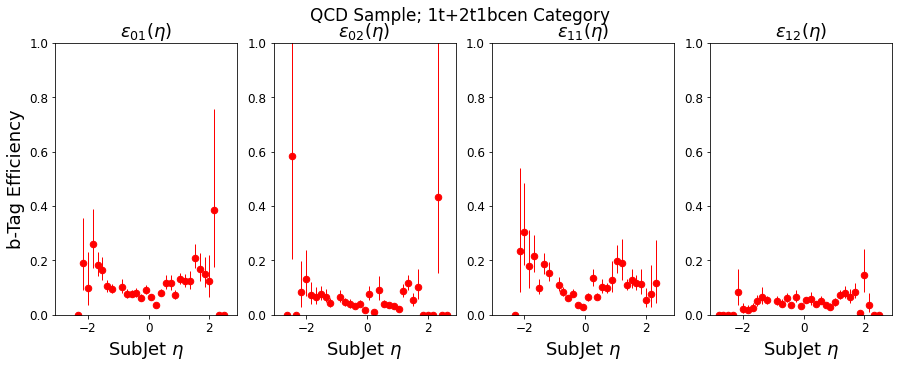

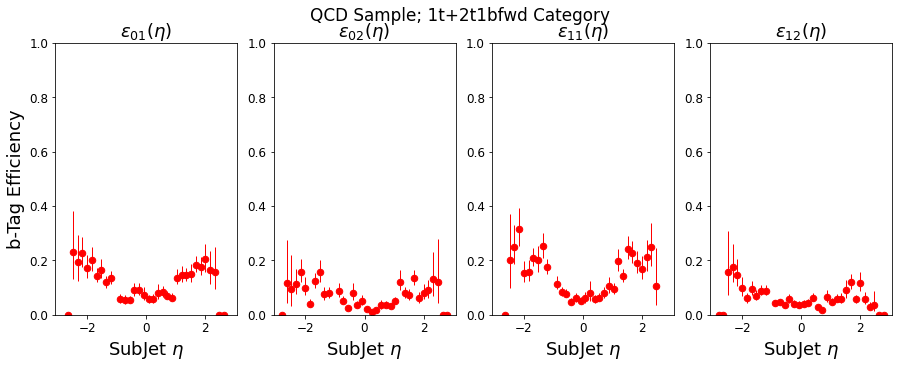

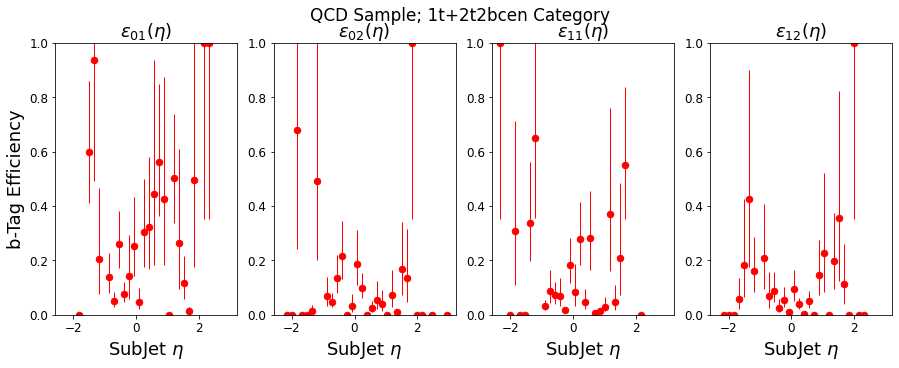

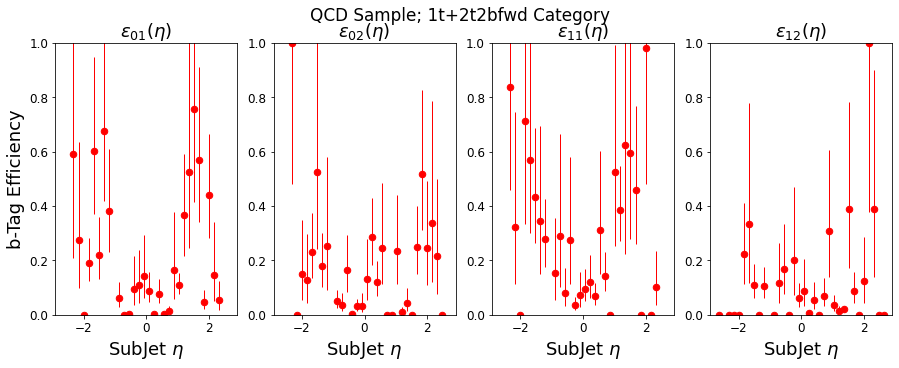

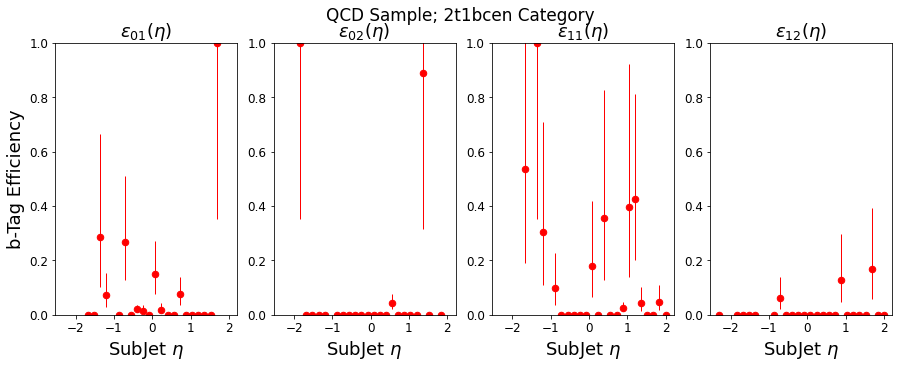

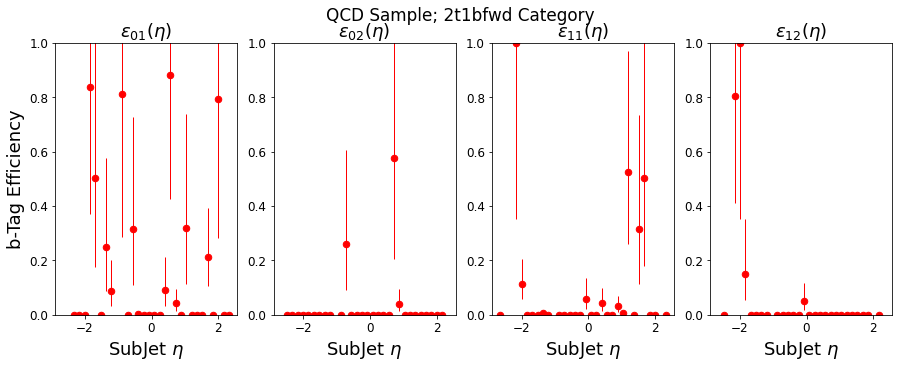

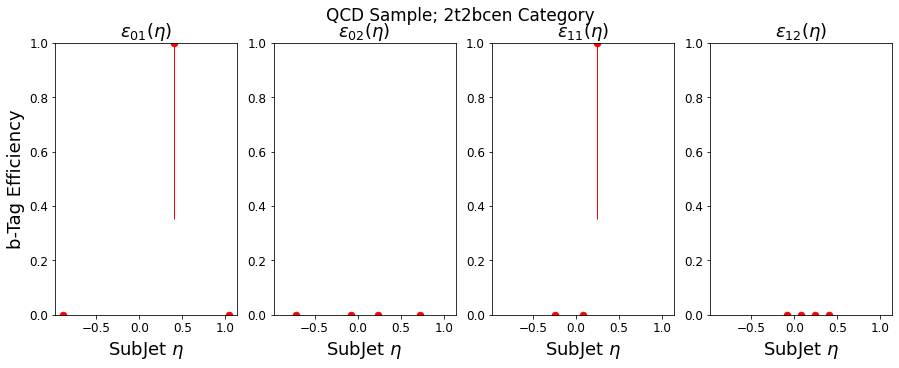

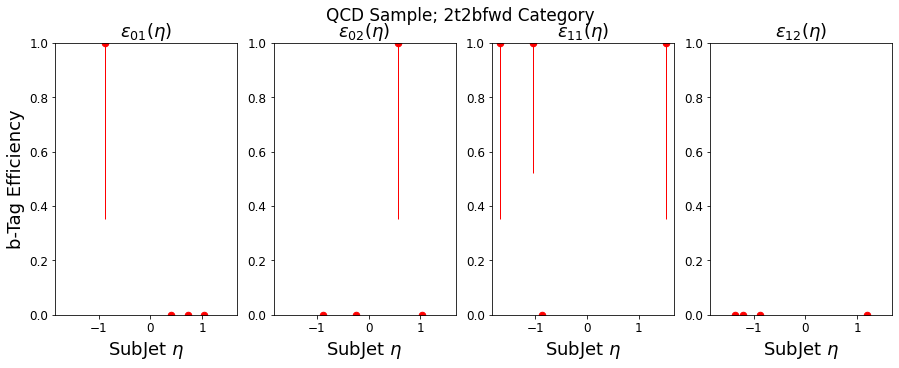

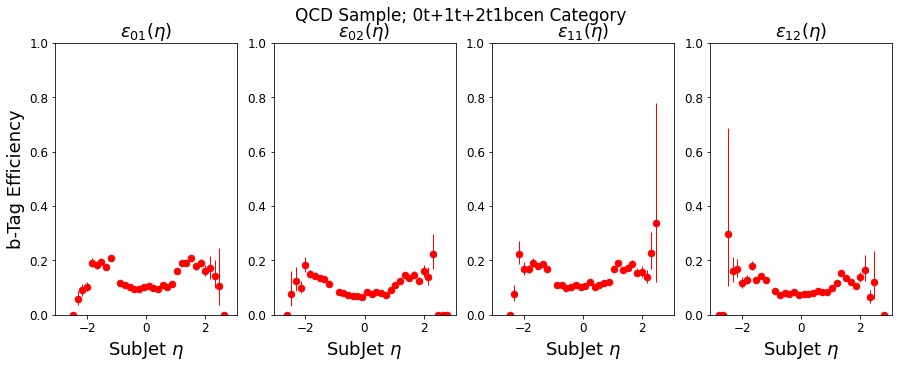

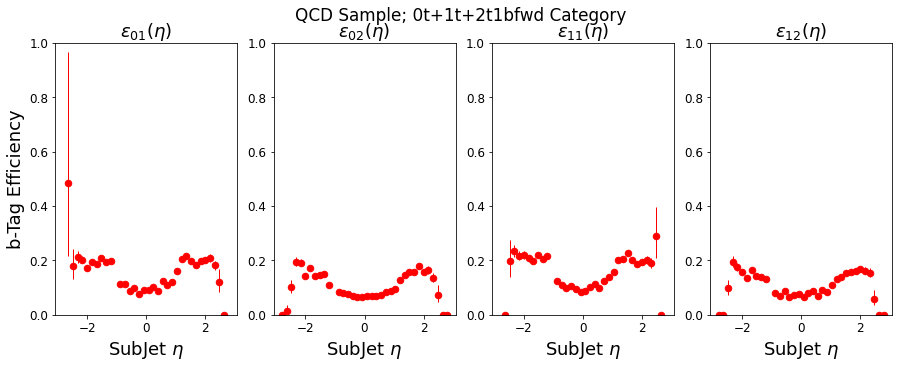

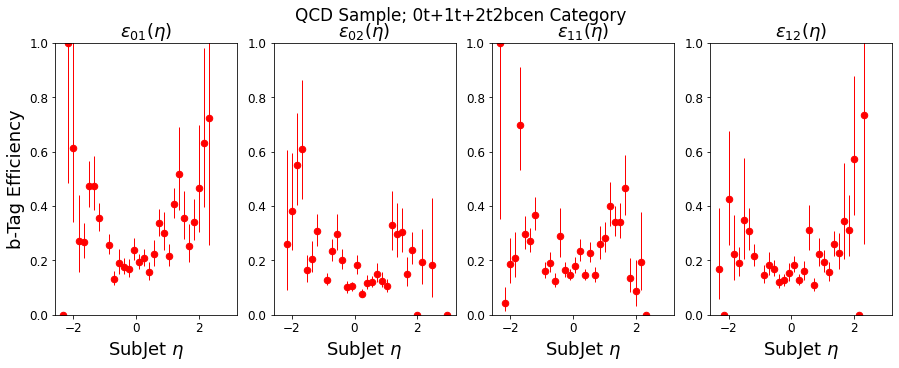

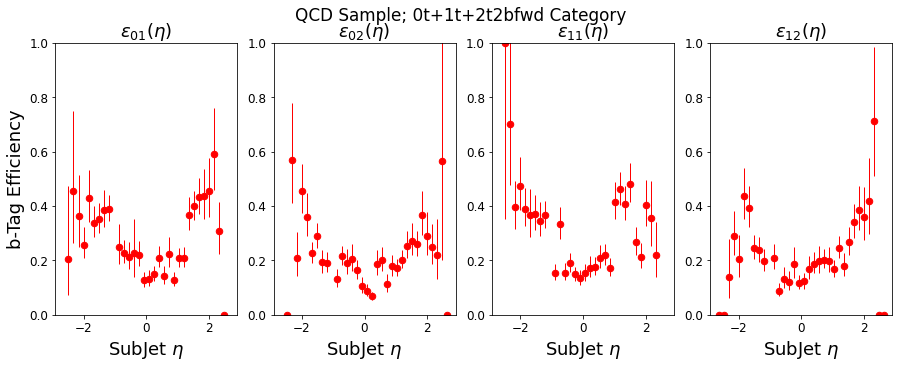

In [9]:
# SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
# DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
for icat in list_of_cats: 
    if not '0b' in icat:
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax01, ax02, ax11, ax12) = plt.subplots(1, 4, figsize=(15,5), sharex=True)

        QCD_b_eff_numerator_eta_s01 = QCD_unweighted['b_eff_numerator_eta_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_eta_s01 = QCD_unweighted['b_eff_denominator_eta_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_eta_s01 = hist.plotratio(num = QCD_b_eff_numerator_eta_s01, denom = QCD_b_eff_denominator_eta_s01, 
                                      ax=ax01, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax01.set_title(r'$\epsilon_{01}\left(\eta\right)$')
        ax01.set_ylabel('b-Tag Efficiency')
        ax01.set_ylim(bottom=0., top=1.)

        # ------------------------------------------------------------------------------ #

        QCD_b_eff_numerator_eta_s02 = QCD_unweighted['b_eff_numerator_eta_s02'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_eta_s02 = QCD_unweighted['b_eff_denominator_eta_s02'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_eta_s02 = hist.plotratio(num = QCD_b_eff_numerator_eta_s02, denom = QCD_b_eff_denominator_eta_s02, 
                                      ax=ax02, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax02.set_title(r'$\epsilon_{02}\left(\eta\right)$')
        ax02.set_ylabel('')
        ax02.set_ylim(bottom=0., top=1.)

        # ------------------------------------------------------------------------------ #

        QCD_b_eff_numerator_eta_s11 = QCD_unweighted['b_eff_numerator_eta_s11'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_eta_s11 = QCD_unweighted['b_eff_denominator_eta_s11'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_eta_s11 = hist.plotratio(num = QCD_b_eff_numerator_eta_s11, denom = QCD_b_eff_denominator_eta_s11, 
                                      ax=ax11, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax11.set_title(r'$\epsilon_{11}\left(\eta\right)$')
        ax11.set_ylabel('')
        ax11.set_ylim(bottom=0., top=1.)

        # ------------------------------------------------------------------------------ #

        QCD_b_eff_numerator_eta_s12 = QCD_unweighted['b_eff_numerator_eta_s12'].integrate('anacat', icat).integrate('dataset', 'QCD')
        QCD_b_eff_denominator_eta_s12 = QCD_unweighted['b_eff_denominator_eta_s12'].integrate('anacat', icat).integrate('dataset', 'QCD')

        b_eff_eta_s12 = hist.plotratio(num = QCD_b_eff_numerator_eta_s12, denom = QCD_b_eff_denominator_eta_s12, 
                                      ax=ax12, clear=False,
                                      error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                      unc = 'num')
        ax12.set_title(r'$\epsilon_{12}\left(\eta\right)$')
        ax12.set_ylabel('')
        ax12.set_ylim(bottom=0., top=1.)

        fig.suptitle('QCD Sample; ' + str(icat) + ' Category')
    else:
        continue

In [ ]:
# SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
# DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
# for icat in list_of_cats: 
#     plt.rcParams.update({
#     'font.size': 14,
#     'axes.titlesize': 18,
#     'axes.labelsize': 18,
#     'xtick.labelsize': 12,
#     'ytick.labelsize': 12
#     })
#     fig, ax = plt.subplots(figsize=(7,5), sharex=True)
#     title = 'QCD Sample; ' + str(icat) + r' Category; $\epsilon_{01}\left(p_T,\ \eta\right)$'
    
#     QCD_b_eff_numerator_s01 = QCD_unweighted['b_eff_numerator_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
#     QCD_b_eff_denominator_s01 = QCD_unweighted['b_eff_denominator_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
    
#     b_eff_pt_s01_2D = hist.plotratio(num = QCD_b_eff_numerator_eta_s01, denom = QCD_b_eff_denominator_eta_s01, 
#                                   ax=ax, clear=False,
#                                   error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
#                                   unc = 'num')
#     ax.set_title(title)
#     ax.set_ylabel('b-Tag Efficiency')
#     plt.ylim(bottom = 0., top = 1.)

In [ ]:
# SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
# DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
for icat in list_of_cats: 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, ax = plt.subplots(figsize=(7,5), sharex=True)
    title = 'QCD Sample; ' + str(icat) + r' Category; $\epsilon_{01}\left(p_T\right)$'
    
    QCD_b_eff_numerator_pt_s01 = QCD_unweighted['b_eff_numerator_pt_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
    QCD_b_eff_denominator_pt_s01 = QCD_unweighted['b_eff_denominator_pt_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
    
    b_eff_pt_s01 = hist.plotratio(num = QCD_b_eff_numerator_pt_s01, denom = QCD_b_eff_denominator_pt_s01, 
                                  ax=ax, clear=False,
                                  error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                  unc = 'num')
    ax.set_title(title)
    ax.set_ylabel('b-Tag Efficiency')
    plt.ylim(bottom = 0., top = 1.)

In [ ]:
# SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
# DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
for icat in list_of_cats: 
    plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
    })
    fig, ax = plt.subplots(figsize=(7,5), sharex=True)
    title = 'QCD Sample; ' + str(icat) + r' Category; $\epsilon_{01}\left(\eta\right)$'
    
    QCD_b_eff_numerator_eta_s01 = QCD_unweighted['b_eff_numerator_eta_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
    QCD_b_eff_denominator_eta_s01 = QCD_unweighted['b_eff_denominator_eta_s01'].integrate('anacat', icat).integrate('dataset', 'QCD')
    
    b_eff_pt_s01 = hist.plotratio(num = QCD_b_eff_numerator_eta_s01, denom = QCD_b_eff_denominator_eta_s01, 
                                  ax=ax, clear=False,
                                  error_opts={'marker': '.', 'markersize': 13., 'color': 'r', 'elinewidth': 1},
                                  unc = 'num')
    ax.set_title(title)
    ax.set_ylabel('b-Tag Efficiency')
    plt.ylim(bottom = 0., top = 1.)